<center><h1> BottleNeck

## Importation de libraries

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
#Gestion des options d'affichage 
pd.set_option('display.max_row',1000)
pd.set_option('display.max_columns',30)

## Chargement de données

### ERP contient les références produit, leur prix de vente et leur état de stock.

In [3]:
erp = pd.read_excel('erp.xlsx', sep=',')
print("Shape: ",erp.shape)
print( "Produits uniques: ",erp.product_id.nunique())
erp.head(3)

Shape:  (825, 5)
Produits uniques:  825


,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock


### CMS contient les informations des produits commercialisés en ligne (nom, description, nombre de ventes...)

In [4]:
web = pd.read_excel('web.xlsx', sep=',')
print("shape: ", web.shape)
web.head(3)

shape:  (1513, 28)


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,NaN,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


### Liaison data

In [5]:
lien = pd.read_excel('liaison.xlsx', sep=',')
print("Shape: ", lien.shape)
print( "Produits uniques: ", lien.product_id.nunique())
lien.head(3)

Shape:  (825, 2)
Produits uniques:  825


,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300


## Nettoyage et préparation de données 

### ERP 

In [6]:
print(erp.isnull().sum())

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64


### Web

In [7]:
web.isnull().sum()

sku                        85
virtual                     0
downloadable                0
rating_count                0
average_rating             83
total_sales                83
tax_status                797
tax_class                1513
post_author                83
post_date                  83
post_date_gmt              83
post_content             1513
post_title                 83
post_excerpt              797
post_status                83
comment_status             83
ping_status                83
post_password            1513
post_name                  83
post_modified              83
post_modified_gmt          83
post_content_filtered    1513
post_parent                83
guid                       83
menu_order                 83
post_type                  83
post_mime_type            799
comment_count              83
dtype: int64

In [8]:
# Eliminer les colonnes avec tous ses valeurs manquants et en zéros

web.drop(['virtual','downloadable','rating_count','average_rating','tax_class', 'post_content', 'post_password', 'post_content_filtered'], axis=1, inplace=True)

# Renomer les colonnes
web.columns = ['id_web', 'total_sales', 'tax_status', 'post_author', 'post_date',
       'post_date_gmt', 'post_title', 'post_excerpt', 'post_status',
       'comment_status', 'ping_status', 'post_name', 'post_modified',
       'post_modified_gmt', 'post_parent', 'guid', 'menu_order', 'post_type',
       'post_mime_type', 'comment_count']

# Eliminer 83 lignes avec the valuers manquantes
web.loc[web['total_sales'].isnull()]
web.drop(web.loc[web['total_sales'].isnull()].index, inplace=True)
print("Shape après éliminer 83 lignes:",web.shape)

# Prendre que les produits
web = web[web['post_type'] == 'product']
print("Shape final:",web.shape)

Shape après éliminer 83 lignes: (1430, 20)
Shape final: (716, 20)


### Liaison 

In [9]:
print(lien.isnull().sum())

product_id     0
id_web        91
dtype: int64


## Jointure 

### Données ERP et données Liaison

In [10]:
lien_erp = pd.merge(lien, erp, on ='product_id', how='outer', indicator=True)
print(lien_erp.shape)
lien_erp.head()

(825, 7)


,product_id,id_web,onsale_web,price,stock_quantity,stock_status,_merge
0,3847,15298,1,24.2,0,outofstock,both
1,3849,15296,1,34.3,0,outofstock,both
2,3850,15300,1,20.8,0,outofstock,both
3,4032,19814,1,14.1,0,outofstock,both
4,4039,19815,1,46.0,0,outofstock,both


In [11]:
df_test_join = lien_erp[lien_erp['_merge']!='both']
df_test_join 

,product_id,id_web,onsale_web,price,stock_quantity,stock_status,_merge


In [12]:
lien_erp = pd.merge(lien, erp, on ='product_id', how='outer')

### Donées ERP, donées Liaison et données web

In [13]:
ventes= pd.merge(lien_erp, web, on ='id_web', how ='outer')
print("Shape: ",ventes.shape)
ventes.head(3)

Shape:  (916, 25)


,product_id,id_web,onsale_web,price,stock_quantity,stock_status,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,3847,15298,1,24.2,0,outofstock,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,3849,15296,1,34.3,0,outofstock,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,3850,15300,1,20.8,0,outofstock,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


## Calculer le chiffre d'affaires

In [14]:
ventes['CA'] = ventes['price'] * ventes['total_sales']
print("CA: ", ventes['CA'].sum())

CA:  70568.6


## Trouver les  outliers

### Méthode des interquartiles

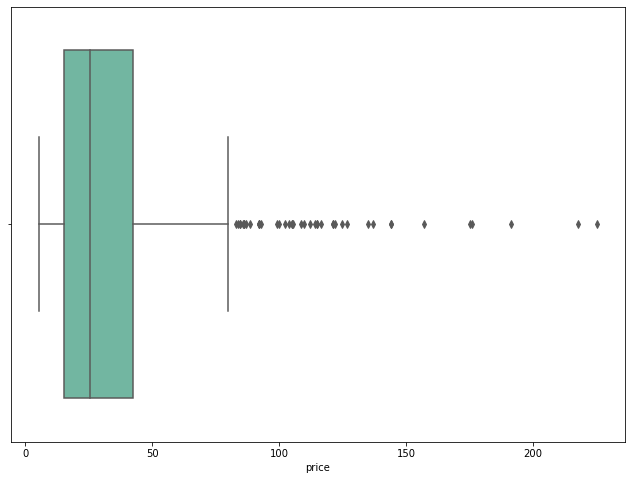

In [15]:
dims = (11, 8)
fig, ax = plt.subplots(figsize= dims)
ax = sns.boxplot(x=ventes["price"], palette="Set2")

In [16]:
def valeurs_aberrantes (d):
    Q1 = np.quantile(d, 0.25)
    Q3 = np.quantile(d, 0.75)
    EIQ = Q3 - Q1 # Eˊcart interquartile
    LI = Q1 - (EIQ * 1.5)
    LS = Q3 + (EIQ * 1.5)
    
    i = list(d.index [(d < LI) |( d > LS ) ])
    v = list(d[i])
    
    return i, v

outliers = valeurs_aberrantes(ventes['price'])
idx_outliers = outliers[0]# index


print("Nombre d'outliers: ", len(idx_outliers))

Nombre d'outliers:  42


In [17]:
ventes[ventes.index.isin(idx_outliers)].price

19      86.1
20      86.1
41     144.0
42     144.0
75      84.7
76      84.7
91      92.0
92      92.0
245    100.0
247     88.4
379     83.0
382    225.0
384    126.5
388     85.6
401    176.0
402    108.5
404    157.0
405    104.0
411    109.6
568    102.3
569    137.0
616    217.5
621    105.0
622    105.0
629    112.0
630     86.8
696     92.0
701     83.7
706    124.8
748    175.0
783    191.3
798     93.0
799    122.0
800    114.0
843    135.0
848    105.6
849    116.4
854    115.0
855    121.0
856     99.0
857    115.0
858    121.0
Name: price, dtype: float64

### Méthode du z score

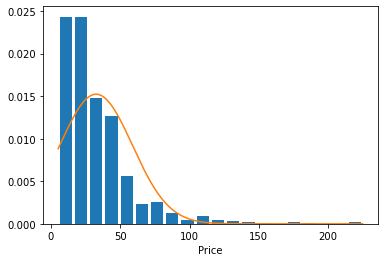

In [18]:
plt.hist(ventes.price, bins=20, rwidth=0.8, density=True)
plt.xlabel('Price')

rng = np.arange(ventes.price.min(), ventes.price.max(), 0.1)
plt.plot(rng, norm.pdf(rng,ventes.price.mean(),ventes.price.std()))
plt.show()

In [19]:
ventes['zscore'] = ( ventes.price - ventes.price.mean() ) / ventes.price.std()
ventes[['price','zscore']] .head()

,price,zscore
0,24.2,-0.319706
1,34.3,0.065855
2,20.8,-0.449498
3,14.1,-0.705266
4,46.0,0.512494


In [35]:
print("Nombre d'outliers: ",ventes[(ventes.zscore<-2) | (ventes.zscore>2)].shape[0])
outliers =ventes[(ventes.zscore<-2) | (ventes.zscore>2)]

Nombre d'outliers:  38


In [43]:
outliers.reset_index(drop=True, inplace=True)
outliers[['post_title','price','zscore']].sort_values(by='price')

,post_title,price,zscore
10,Champagne Larmandier-Bernier Grand Cru Les Che...,85.6,2.024197
0,Pierre Jean Villa Côte Rôtie Fongeant 2017,86.1,2.043284
1,Pierre Jean Villa Condrieu Jardin Suspendu 2018,86.1,2.043284
22,Champagne Agrapart &amp; Fils Minéral Extra Br...,86.8,2.070006
7,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,88.4,2.131085
23,Tempier Bandol Cabassaou 2017,92.0,2.268512
4,Pierre Jean Villa Côte Rôtie Fongeant 2017,92.0,2.268512
5,Pierre Jean Villa Condrieu Jardin Suspendu 2018,92.0,2.268512
27,Wemyss Malts Single Cask Scotch Whisky Chocola...,93.0,2.306687
35,Domaine des Comtes Lafon Volnay 1er Cru Champa...,99.0,2.535733


### Visualization avec Scaterplot

In [37]:
ventes['outlier'] = np.where((ventes['zscore'] < -2 ) | (ventes['zscore'] > 2), 'oui', 'non')
ventes.head(3)
outliers= ventes.loc[ventes['outlier'] == 'oui']

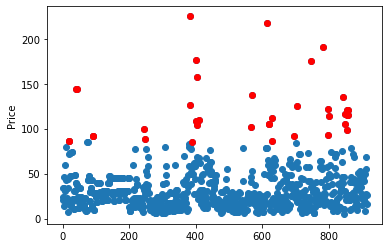

In [38]:
plt.scatter(ventes['price'].index, ventes['price'].values)
plt.scatter(outliers['price'].index, outliers['price'].values,c='red')
plt.ylabel('Price')
plt.show()